In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
from tqdm.notebook import tqdm
import contextily as cx
import matplotlib.pyplot as plt
ox.settings.cache_folder = "../cache/"

In [2]:
tracts = gpd.read_file("../data/tl_2022_23_tract_with_nodes/tl_2022_23_tract_with_nodes.shp")

In [3]:
conserved_lands = gpd.read_file("../data/Maine_Conserved_Lands_with_nodes/Maine_Conserved_Lands_with_nodes.shp")

In [4]:
G = ox.load_graphml("../data/maine_walk.graphml")
G = ox.project_graph(G, 'EPSG:3857')

In [5]:
# configure trip times and travel speed
trip_times = [5, 10, 15, 20, 30, 45, 60]  # in minutes
travel_speed = 4.5  # walking speed in km/hour
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [6]:
def get_lands(center_node = 102322137):
    node_times = {}
    # loop over allowed trip times, reversed to ensure lowest trip time is selected
    for trip_time in reversed(trip_times):
        # find subgraph from center node
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
        # set node distance to current trip_time
        for node in subgraph.nodes():
            node_times[node] = trip_time

    full_dict = {int(node) : node_times[int(node)] if int(node) in node_times else None for node in conserved_lands["osmid"].values}
    return [[center_node, k, v] for k, v in full_dict.items() if v is not None]

In [7]:
df = pd.DataFrame.from_records([land for node in tqdm(tracts["osmid"].values) for land in get_lands(node)], columns=["tract_osmid","land_osmid","trip_time"])

<AxesSubplot: >

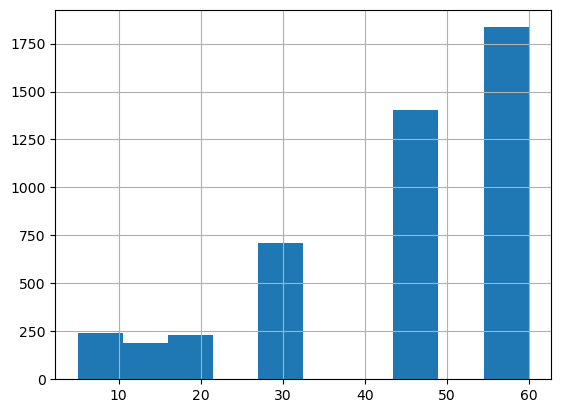

In [8]:
df["trip_time"].hist()

In [9]:
df.to_csv("../data/walk_times_tract_df.csv")